In [1]:
import pandas as pd
import sqlalchemy as db
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
'imports complete'

'imports complete'

In [2]:
engine = db.create_engine('sqlite:///viewpoint.db')

In [3]:
name_dict = {"StudentID":["V001","V002", "V003", "V004"],"Name":["Abe", "Abhay", "Acelin", "Adelphos"]}
df = pd.DataFrame.from_dict(name_dict).set_index("StudentID")
df.to_sql('name_table', con=engine)
engine.execute("SELECT * FROM name_table").fetchall()

[('V001', 'Abe'), ('V002', 'Abhay'), ('V003', 'Acelin'), ('V004', 'Adelphos')]

In [4]:
mark_dict = {"StudentID":["V001","V002", "V003", "V004"],"Total_marks":[95, 80, 74, 81]}
df2 = pd.DataFrame.from_dict(mark_dict).set_index("StudentID")
df2.to_sql('mark_table', con=engine)
engine.execute("SELECT * FROM mark_table").fetchall()

[('V001', 95), ('V002', 80), ('V003', 74), ('V004', 81)]

<h1>My Responses to the Viewpoint Questions:</h1>

<h1>1a).</h1>

Clearly, we want to select the **Name** from the name table and the **StudentID** from really either table (I chose mark_table). It will be easiest to select based on Total_mark if we join the tables on ID.

What's tricky here is making the code reusable so that if Student V002's Total_mark updates, we still get the correct values with this query. I implemented this tricky part in the final line of my query to grab the average of one row's total_mark column, V002's total mark, and selecting only rows with total marks greater than this value.

In [21]:
query = '''
SELECT 
name_table.Name, mark_table.StudentID
FROM name_table
INNER JOIN mark_table
ON name_table.StudentID = mark_table.StudentID
WHERE Total_marks > (SELECT AVG(mark_table.Total_marks) FROM mark_table WHERE mark_table.StudentID ='V002');
'''

pd.read_sql(query, engine)

,Name,StudentID
0,Abe,V001
1,Adelphos,V004


<h1>1b).</h1>

If we make a new dataframe with a column to indicate whether the name includes an 'e' (either True or False), than we can easily update the name to either uppercase or lowercase based on this new column. Then, all we need to do is return this dataframe without the column we created. Now we have an updated name column!

In [7]:
def containsE(df):
    new = df.copy()  # make copy of dataframe
    new["Name"] = new["Name"].str.lower()  # assume that there are no e's in name
    new["containsE"] = df["Name"].str.find("e") != -1  # create temp column where value is 1 when 'e' is present; else 0
    new.loc[new["containsE"]==True, "Name"] = new["Name"].str.upper()  # conditionally update name column to uppercase
    return new[["Name"]]  # return new df where id name is the only column (and index of id)

containsE(df)

,Name
StudentID,
V001,ABE
V002,abhay
V003,ACELIN
V004,ADELPHOS


<h1>1c).</h1>

Now we want to take the table we created in part b and return the average of the uppercase letters and the average of the lowercase letters. We can do this by first combining the two dataframes, then in a similar fashion to part b, creating a new column to indicate whether it is an uppercase or lowercase name. From here it is very simple to average the total_marks of the uppercase names and lowercase names separately. 

I chose to return a string to clarify what the solved numbers were. However, you could just as easily return only the numbers by modifying the return statement to say **"return upper, lower"**

In [22]:
def summarize(df1, df2):
    new = pd.concat([df1, df2], axis=1)  # add the tables together
    new["upper"] = new["Name"].str.isupper()  # cretae a new boolean column to describe if the name is uppercase or not
    upper = round(new[new["upper"]==True]["Total_marks"].mean(), 1)  # average the uppercase names
    lower = round(new[new["upper"]==False]["Total_marks"].mean(), 1) # average the lowercase names
    return f'The average score of uppercase names is {upper}, while the average score of lowercase names is {lower}'
    

print(summarize(containsE(df), df2))

The average score of uppercase names is 83.3, while the average score of lowercase names is 80.0


<h1>2).</h1>

In [23]:
wh = pd.read_csv('2017.csv')  # read our csv file into a dataframe
wh

,NAME,STATUS,SALARY,PAY BASIS,POSITION TITLE
0,"Alexander, Monica K.",Employee,"$56,000.00",Per Annum,EXECUTIVE ASSISTANT
1,"Ambrosini, Michael J.",Employee,"$95,000.00",Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND DIRECTO...
2,"Amin, Stacy C.",Employee,"$140,000.00",Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND ASSOCIA...
3,"Andersen, Whitney N.",Employee,"$94,000.00",Per Annum,DEPUTY DIRECTOR OF OPERATIONS FOR THE WHITE HO...
4,"Anderson, Alexander J.",Employee,"$77,000.00",Per Annum,DIRECTOR OF DIGITAL ENGAGEMENT
...,...,...,...,...,...
372,"Winfree, Paul L.",Employee,"$155,000.00",Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DEPUTY D...
373,"Worthington, Ross P.",Employee,"$130,000.00",Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND ADVISOR...
374,"Young, Jr., Reginald D.",Employee,"$72,648.00",Per Annum,SENIOR RECORDS MANAGEMENT ANALYST
375,"Zadrozny, John A.",Employee,"$95,000.00",Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT FOR JUSTICE...


First, having our 'SALARY' column as a string with dollar signs is not very useful. Let's modify the 'SALARY' column to contain integer values:

In [13]:
import re  # using regex makes this simple!

wh["SALARY"] = wh["SALARY"].apply(lambda x: int(re.sub('[^0-9]','', x))) # get rid of commas and $ and cast as int
wh

,NAME,STATUS,SALARY,PAY BASIS,POSITION TITLE
0,"Alexander, Monica K.",Employee,5600000,Per Annum,EXECUTIVE ASSISTANT
1,"Ambrosini, Michael J.",Employee,9500000,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND DIRECTO...
2,"Amin, Stacy C.",Employee,14000000,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND ASSOCIA...
3,"Andersen, Whitney N.",Employee,9400000,Per Annum,DEPUTY DIRECTOR OF OPERATIONS FOR THE WHITE HO...
4,"Anderson, Alexander J.",Employee,7700000,Per Annum,DIRECTOR OF DIGITAL ENGAGEMENT
...,...,...,...,...,...
372,"Winfree, Paul L.",Employee,15500000,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DEPUTY D...
373,"Worthington, Ross P.",Employee,13000000,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND ADVISOR...
374,"Young, Jr., Reginald D.",Employee,7264800,Per Annum,SENIOR RECORDS MANAGEMENT ANALYST
375,"Zadrozny, John A.",Employee,9500000,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT FOR JUSTICE...


Next, it might be nice to have a first name and a last name column:

In [14]:
last = r'[a-zA-Z]*'  # once again, lets use regex!
wh["LAST NAME"] = wh["NAME"].apply(lambda x: re.findall(last, x)[0])
wh["FIRST NAME"] = wh["NAME"].apply(lambda x: re.split("\s", x)[1])
wh

,NAME,STATUS,SALARY,PAY BASIS,POSITION TITLE,LAST NAME,FIRST NAME
0,"Alexander, Monica K.",Employee,5600000,Per Annum,EXECUTIVE ASSISTANT,Alexander,Monica
1,"Ambrosini, Michael J.",Employee,9500000,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND DIRECTO...,Ambrosini,Michael
2,"Amin, Stacy C.",Employee,14000000,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND ASSOCIA...,Amin,Stacy
3,"Andersen, Whitney N.",Employee,9400000,Per Annum,DEPUTY DIRECTOR OF OPERATIONS FOR THE WHITE HO...,Andersen,Whitney
4,"Anderson, Alexander J.",Employee,7700000,Per Annum,DIRECTOR OF DIGITAL ENGAGEMENT,Anderson,Alexander
...,...,...,...,...,...,...,...
372,"Winfree, Paul L.",Employee,15500000,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DEPUTY D...,Winfree,Paul
373,"Worthington, Ross P.",Employee,13000000,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND ADVISOR...,Worthington,Ross
374,"Young, Jr., Reginald D.",Employee,7264800,Per Annum,SENIOR RECORDS MANAGEMENT ANALYST,Young,"Jr.,"
375,"Zadrozny, John A.",Employee,9500000,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT FOR JUSTICE...,Zadrozny,John


<h3>Nice! Now let's look at the data file</h3>

In [25]:
data = pd.read_csv('data.csv', header=None, index_col=0).rename(columns={1:"Data"})  # read our csv file into a dataframe
data

,Data
0,
0,23.827290
1,23.589108
2,24.529556
3,16.684580
4,22.075507
...,...
9995,18.593941
9996,18.466305
9997,28.286995


In pandas, it is very easy to generate descriptive statistics for a dataframe's numerical columns.

In [26]:
data.describe()

,Data
count,10000.000000
mean,23.036075
std,2.995296
min,11.248686
25%,21.007801
50%,23.024042
75%,25.069083
max,33.286533


It is now clear that the mean of the data is ~23, there are 10,000 rows, the minimum value is 11.24, the maximum value is 33.29 etc.

Now let's plot the data values to get a better idea of the distribution of data.

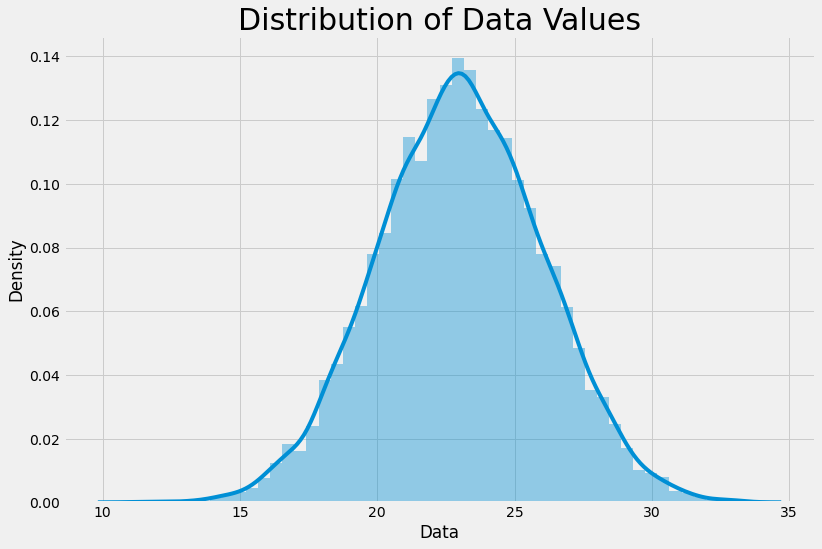

In [30]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # I want to use a specific plot and I don't want the warning :)


plt.figure(figsize=(12, 8))
sns.distplot(data["Data"])
plt.title("Distribution of Data Values", fontsize=30);

We can now also see that the data is approximately **normally distributed**!

<h1>3).</h1>

Assuming that our column is numerical, it might make sense to replace NULL values with the mean of the data set. This way, we don't lose data but we also do not greatly change the characteristics of the column.

Assuming the column is NOT numerical, it might make the most sense to simply replace NULL values with the value that is most frequent in this column. This way, we do not lose data, either.

<h1>4).</h1>

I am almost never am awake at 2am, so I would probably do this in the morning closer to 7am or 8am. If the task MUST be done before then, I would do it Wednesday night. If the task HAD to be done at 2:00am, I would want to find a way to automate it then check up on the data in the morning after to verify :)

Maybe I would want to automate it regardless... 365 GB would take a while to sift through!

As far as tools go, I assume you would want to use tools that manage such large data sets well. That being said, I have not worked with such large data sets before and I do not want to pretend to be knowledgeable about the practices. I CAN say that the time complexity of the solution you choose needs to be as fast as possible. This way, time is not wasted through poor implementations.

<h1>5).</h1>

Right now, my favorite computer scientist(s) is Satoshi Nakamoto. Satoshi Nakamoto is the anonymous inventer of bitcoin and the first blockchain database. In my opinion, these inventions may prove to be some of the more influential inventions in recent memory! 